<a href="https://colab.research.google.com/github/vvikasreddy/JargonAI/blob/main/Summa_rizzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and Downloading libraries

In [1]:
# downloading necessary libraries
!pip install datasets
!pip install rouge_score
!pip install bert-score
!pip install evaluate

In [2]:
# importing libraries
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AdamW
from torch.utils.data import DataLoader, Dataset
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import textwrap
from tqdm import tqdm

# Loading the data and Pre-processing




In [3]:
#loading the dataset
dataset_path = "/content/Corpus_all.csv"
data = pd.read_csv(dataset_path, encoding="ISO-8859-1")

In [4]:
data.head()

,Document,Summary
0,412.106.1 English is not an official language ...,The Swiss Federal University for Vocational Ed...
1,944.021.1 English is not an official language ...,The EAER Ordinance on the Declaration for Timb...
2,Title and commencement 1 This order may be cit...,The North West Water Authority (Solway Firth) ...
3,Citation and commencement 1 This order may be ...,The Trafford Park Development Corporation (Are...
4,"Title, commencement and interpretation 1 1 Thi...",The North West Water Authority (Returns of Eel...


In [5]:

# putting the text and summaries into the containers
input_texts = data["Document"].tolist()
target_texts = data["Summary"].tolist()

In [6]:
# taking a look at the first index
print(input_texts[0])
print(target_texts[0])

412.106.1 English is not an official language of the Swiss Confederation. This translation is provided for information purposes only, has no legal force and may not be relied on in legal proceedings. Ordinance on the Swiss Federal University for Vocational Education and Training(SFUVET Ordinance)of 18 June 2021 (Status as of 1 August 2021)The Swiss Federal Council,on the basis of Article 35 of the SFUVET Act of 25 September 20201,ordains:1 SR 412.106Art. 1 Registered location The Swiss Federal University for Vocational Education and Training (SFUVET) shall be based in Zollikofen.Art. 2 Regional campuses SFUVET shall offer its services through three regional campuses: one in the German-speaking region, one in the French-speaking region and one in the Italian-speaking region of Switzerland.Art. 3 Federal Council's strategic objectives The Federal Department of Economic Affairs, Education and Research (EAER) shall submit SFUVET's strategic objectives drafted by the Federal Council to the 

In [7]:
#initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
#define the custom dataset class

class CustomDataset(Dataset):
    def __init__(self, tokenizer, input_texts, target_texts, max_input_length=512, max_target_length=128):
        self.tokenizer = tokenizer
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_encoding = self.tokenizer(
            self.input_texts[idx],
            max_length=self.max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        target_encoding = self.tokenizer(
            self.target_texts[idx],
            max_length=self.max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": input_encoding["input_ids"].squeeze(),
            "attention_mask": input_encoding["attention_mask"].squeeze(),
            "labels": target_encoding["input_ids"].squeeze(),
        }



In [9]:
# Split the dataset into training and testing sets
train_input_texts, test_input_texts, train_target_texts, test_target_texts = train_test_split(
    input_texts, target_texts, test_size=0.1, random_state=42
)

# Create datasets for train, validation, and test
train_dataset = CustomDataset(tokenizer, train_input_texts, train_target_texts)
test_dataset = CustomDataset(tokenizer, test_input_texts, test_target_texts)

batch_size = 32
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Model training

In [10]:
#set up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
#training loop
loss = float('inf')

epochs = 65

train_loss = []
validation_loss = []

model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
    train_loss.append(epoch_loss / len(train_dataloader))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_dataloader)}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
    validation_loss.append(val_loss / len(test_dataloader))
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss / len(test_dataloader)}")

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1/65, Loss: 7.358024597167969
Epoch 1/65, Validation Loss: 4.955554485321045
Epoch 2/65, Loss: 6.439593553543091
Epoch 2/65, Validation Loss: 4.693390369415283
Epoch 3/65, Loss: 6.013429641723633
Epoch 3/65, Validation Loss: 4.457711219787598
Epoch 4/65, Loss: 5.6314544677734375
Epoch 4/65, Validation Loss: 4.248648166656494
Epoch 5/65, Loss: 5.530635356903076
Epoch 5/65, Validation Loss: 4.063544273376465
Epoch 6/65, Loss: 5.192427635192871
Epoch 6/65, Validation Loss: 3.8855931758880615
Epoch 7/65, Loss: 4.904496669769287
Epoch 7/65, Validation Loss: 3.717493772506714
Epoch 8/65, Loss: 4.778454780578613
Epoch 8/65, Validation Loss: 3.558664560317993
Epoch 9/65, Loss: 4.235716104507446
Epoch 9/65, Validation Loss: 3.4164607524871826
Epoch 10/65, Loss: 4.21382462978363
Epoch 10/65, Validation Loss: 3.2920055389404297
Epoch 11/65, Loss: 3.856784224510193
Epoch 11/65, Validation Loss: 3.1806490421295166
Epoch 12/65, Loss: 3.692013382911682
Epoch 12/65, Validation Loss: 3.0894613265

## Evaluating of the Model

In [12]:

def evaluate_model(dataset, tokenizer, model):
    model.eval()
    predictions = []
    references = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=256)
            predictions.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
            references.extend([tokenizer.decode(ref, skip_special_tokens=True) for ref in batch["labels"]])
    return predictions, references

In [13]:
#run evaluation
predictions, references = evaluate_model(test_dataset, tokenizer, model)

Evaluating: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


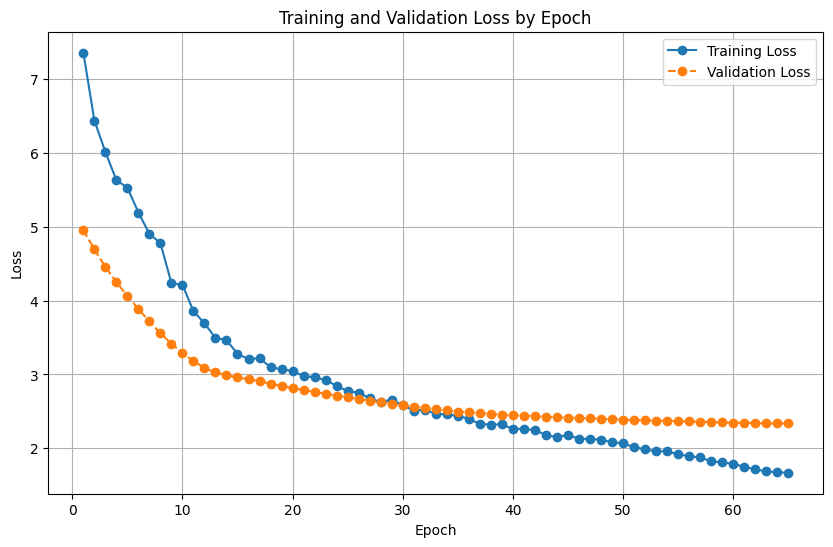

In [14]:
#plotting the loss function against train and test epochs

# Setting up the graph
epochs = range(1, len(train_loss) + 1)  # Generate epoch numbers
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(epochs, validation_loss, label="Validation Loss", marker="o", linestyle="--")

# Adding labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss by Epoch")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [15]:

# Calculate ROUGE Scores
def calculate_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    for ref, pred in zip(references, predictions):
        scores = scorer.score(ref, pred)
        for key in rouge_scores:
            rouge_scores[key].append(scores[key].fmeasure)
    return {key: sum(values) / len(values) for key, values in rouge_scores.items()}

rouge_scores = calculate_rouge(predictions, references)
print(f"ROUGE Scores: {rouge_scores}")

ROUGE Scores: {'rouge1': 0.3401572595849989, 'rouge2': 0.11691605211437595, 'rougeL': 0.23937337407269288}


In [16]:
# Calculate BERT Scores
def calculate_bert_score(predictions, references):
    P, R, F1 = bert_score(predictions, references, model_type="bert-base-uncased", lang="en")
    return {
        "Precision": P.mean().item(),
        "Recall": R.mean().item(),
        "F1": F1.mean().item()
    }

bert_scores = calculate_bert_score(predictions, references)
print(f"BERT Scores: {bert_scores}")

BERT Scores: {'Precision': 0.589675784111023, 'Recall': 0.5940993428230286, 'F1': 0.5906026363372803}


In [17]:
# printing the summary predictions on the test set

# code to beautify the print statements
line_width = 145

for indx, val in enumerate(predictions):
    print(f"Reference {indx + 1}:\n{textwrap.fill(references[indx], width=line_width)}")
    print(f"Prediction {indx + 1}:\n{textwrap.fill(val, width=line_width)}")
    print("-" * 30)

Reference 1:
The Swiss Federal University for Vocational Education and Training (SFUVET) is based in Zollikofen and has 3 campuses in Switzerland. These
campuses are separated by the language spoken in the region, which are German, French, and Italilan. It colabortates with industry groups and
regional authorities to plan courses, services, and research. The government sets their goals and consults with national organikzations like
trade unions and employers associations. Old rules have been replaced on August 1, 2021, but a few parts will continue to be active until the end
of 2021.
Prediction 1:
The SFUVET Ordinance is dated June 18, 2020. It is based in Zollikofen, Switzerland. It provides for three regional campuses, one in the German-
speaking region, one in the French-speaking region, and one in the Italian-speaking region. Its strategic objectives include the development of
new training courses and research areas. It may form advisory boards for professional organisations, canto

 references
  
 https://huggingface.co/docs/transformers/model_doc/t5

 model : https://huggingface.co/google/flan-t5-small

 tokenizer : https://huggingface.co/docs/transformers/main_classes/tokenizer

 train test split, sklearn : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

 dataloader : https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

 optimizer : https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html

 rogue score : https://huggingface.co/spaces/evaluate-metric/rouge/blob/main/README.md

 bert_score : https://github.com/Tiiiger/bert_score

 to beautify the print statements: https://www.geeksforgeeks.org/textwrap-text-wrapping-filling-python/